# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2020-2021 учебный год

Лектор: Илья Щуров, Соня Дымченко, Руслан Хайдуров, Максим Бекетов, Павел Егоров

# Семинар 6

Сегодня мы узнаем

* Как работает логистическая регрессия
* Какие метрики используются для задачи классификации
* Зачем нужны полиномиальные признаки

In [1]:
import pandas as pd
import numpy as np
import warnings
import random

random.seed(42)
warnings.filterwarnings('ignore')
%pylab inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 12

Populating the interactive namespace from numpy and matplotlib


# Логистическая регрессия

Рассмотрим искусственный датасет 

In [2]:
np.random.seed(7)

points = np.vstack([np.random.normal((2, 3), 1, (5, 2)), 
                    np.random.normal((6, 2), 1, (5, 2))])
X1 = points[:,0]
X2 = points[:,1]
Y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
data = pd.DataFrame(dict(X1=X1, X2=X2, Y=Y))
data

X1        X2  Y
0  3.690526  2.534063  0
1  2.032820  3.407516  0
2  1.211077  3.002066  0
3  1.999110  1.245276  0
4  3.017658  3.600499  0
5  5.374571  1.828452  1
6  6.505299  1.738644  1
7  5.757251  0.546759  1
8  6.554580  2.123881  1
9  6.274460  0.473475  1

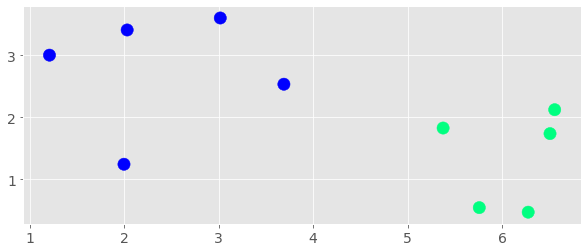

In [3]:
plt.scatter(X1, X2, c=Y, cmap='winter', s=150)
plt.show()

Видим, что классы линейно разделимы. 

Рассмотрим логистическую функцию (сигмоиду):

$$\Large \sigma(x) = \frac{1}{1+e^{-x}}$$

Посмотрим как она трансформирует $x \in [-5, 5]$

In [4]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

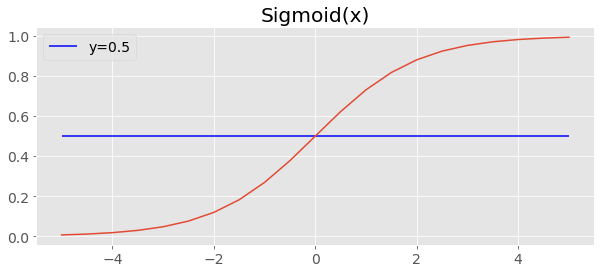

In [5]:
x = np.linspace(start=-5, stop=5, num=21)
plt.hlines(y=0.5, xmin=-5, xmax=5, label='y=0.5', color='b')
plt.plot(x, sigmoid(x))
plt.title("Sigmoid(x)")
plt.legend()
plt.show()

* Выходит, что сигмоида переводит любое числовое значение в интервал от [0, 1].

* В задаче бинарной классификации мы можем рассматривать результат такого преобразования как вероятность принадлежности к положительному классу.

* Если значение сигмоиды больше `0.5`, то можем считать, что предсказали класс `1`, если меньше, то класс `0`.

---

Итак, **Логистическая регрессия = сигмоида(Линейная регрессия)**

Что это значит?

Для нашего игрушечного датасета у логистической регрессии будет ровно столько же параметров сколько и у линейной, т.е. 3.

И выглядит это вот так:

$$
\begin{array}{c}
\Large a(x) = b_0 + b_1 x_1 + b_2 x_2 \\
\Large \mathbb P\{class=0\} = \frac{1}{1 + e^{-a(x)}}\\
\end{array}
$$

Давайте теперь итеративно считать коэффициенты и смотреть как меняются предсказания.

Находить коэффициенты мы будем с помощью градиентного спуска.


In [6]:
# начнем с нулевых значений коэффициентов:

B0 = 0.0

B1 = 0.0

B2 = 0.0

def prediction(x1, x2):
    return sigmoid(B0 + B1 * x1 + B2 * x2)

In [7]:
# для нулевого примера из датасета имеем:

X1[0], X2[0], Y[0]

(3.690525703800356, 2.534062629459167, 0)

In [8]:
# находим предсказание

prediction(X1[0], X2[0])

0.5

Модель не обучена.

## Градиентый спуск для логистической регрессии с квадратичной функцией потерь

На лекции обсуждалось, что логистическую регрессию можно обучать с помощью метода максимизации правдоподобия. Это приводит к некоторой конкретной форме оптимизационной задачи. Но в принципе можно выбрать произвольную функцию потерь и пытаться минимизировать сумму её значения на предсказаниях (эмпирический риск). Давайте попробуем использовать квадртичную функцию потерь (хотя так обычно не делают).

1) Вспомним про функцию потерь, которую мы хотим минимизировать:

$$\Large Loss(y, \hat y) = (y - \hat y)^2,$$

где $\hat y $ - предсказание.
 
2) Посчитайте производную для сигмоиды и выразите ее через саму себя.

3) Выведите производную логистической регрессии по ее параметрам $b_i$

$$LogReg(x) = \sigma(a(x)) = \sigma(b_0 + b_1 x_1 + b_2 x_2)$$

4) Выведем простое правило изменения коэффициентов исходя из посчитанных вами производных:

$$b_i = b_i - \eta \cdot \frac{\partial Loss}{\partial b_i} $$

Здесь $\eta$ — шаг градиентного спуска (в народе `learning_rate`)

In [165]:
# Напишите функцию, возвращающую градиент по b:
# т.е. массив из 3х чисел: [dLoss/db_0, dLoss/db_1, dLoss/db_2]

def get_b_grad(x1, x2, y_true):
    y_pred = prediction(x1, x2)
    db0 = <!> # YOUR CODE
    db1 = <!> # YOUR CODE
    db2 = <!> # YOUR CODE
    return (db0, db1, db2)

* N -- количество эпох, т.е. сколько раз мы кормим полный датасет в цикл обучения
* lr -- learning rate ($\eta$ в наших терминах)

In [166]:
#  Вспоминаем метрику accuracy:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

In [167]:
# Сделаем удобную функцию, чтобы получать предсказания по всему датасету:
def get_pred(X1, X2):
    preds = []
    for x1, x2 in zip(X1, X2):
        preds.append(int(prediction(x1, x2) > 0.5))
    preds = np.array(preds)
    return preds

In [168]:
# Напишите цикл с изменением коэффициентов b_i с фиксированным числом итераций:
N = 200 # количество эпох
lr = 1e-3

# зануляем коэффициенты
B0 = 0.0

B1 = 0.0

B2 = 0.0

accuracy_list = []

# начинаем обучение
for i in range(N):
    for x1, x2, y in zip(X1, X2, Y):
        # считаем градиенты для данного конкретного примера из датасета
        dB0, dB1, dB2 = get_b_grad(x1, x2, y)
        # обновляем параметры логистической регрессии
        B0 = <!> # YOUR CODE
        B1 = <!> # YOUR CODE
        B2 = <!> # YOUR CODE
    # будем считать accuracy в конце каждой эпохи
    accuracy_list.append(accuracy(get_pred(X1, X2), Y))

In [169]:
B0, B1, B2

(-0.0849833319867613, 0.2827636518180686, -0.3968862809326534)

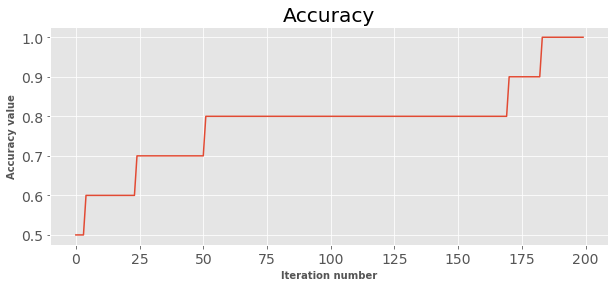

In [170]:
# Построим график роста accuracy от числа эпох:

plt.plot(accuracy_list)
plt.title("Accuracy")
plt.xlabel("Iteration number")
plt.ylabel("Accuracy value")
plt.show()

Поэкспериментируейте со значениями `lr` и `N`, смотрите как меняется график accuracy.

## Время визуализации


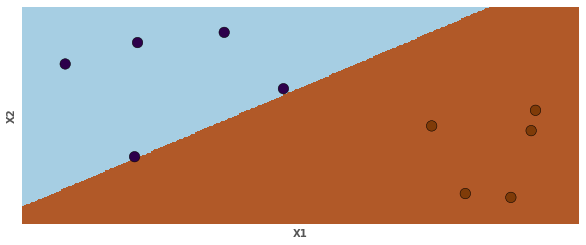

In [171]:
x_min, x_max = X1.min() - .5, X1.max() + .5
y_min, y_max = X2.min() - .5, X2.max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = prediction(xx.ravel(), yy.ravel()) > 0.5

# Z -- значения по сетке логрегрессии
# Просто красим все 0 в синий, а 1 в красный для значений по сетке
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Также не забудем про точки
plt.scatter(X1, X2, c=Y, edgecolors='k', cmap=plt.cm.PuOr_r, s=110)
plt.xlabel('X1')
plt.ylabel('X2')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

# Метрики классификации

<img src="https://cdn-images-1.medium.com/max/1040/1*Hqh7JvLI8pvzB9cUzUOf3g.png" width=300 align="left">

* confusion_matrix
* accuracy_score
* recall_score
* precision_score
* average_precision
* f1_score
* roc_curve
* roc_auc_score

Модель ошибается, поэтому надо измерять то, насколько сильно она ошибается. Какую метрику использовать зависит от задачи и от данных. 

<img src="https://cdn-images-1.medium.com/max/1040/1*hkne2nyU_HPdye2Rzankdg.png" width=400 align="">

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X, Y = load_breast_cancer(return_X_y=True)
X.shape, set(Y)

# Поделим выборку
X_train, X_test, y_train, y_test = train_test_split(X, Y)

# Обучим модель
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

На какие части можно поделить предсказания модели?

## Confusion matrix

<img src="https://tatwan.github.io/images/mock.png" width=400 align="">

## Precision & Recall (точность и полнота)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png" width=400 align="">



Как правило увеличение одной из метрик приводит к просадке другой

<img src="https://camo.githubusercontent.com/d17f71f1f7f47a40e96f57b230f965093a4c2841/68747470733a2f2f7777772e736166617269626f6f6b736f6e6c696e652e636f6d2f6c6962726172792f766965772f68616e64732d6f6e2d6d616368696e652d6c6561726e696e672f393738313439313936323238322f6173736574732f6d6c73745f303330342e706e67" width=400 align="">

## F1_score
Считает сбалансированную метрику между precision & recall
$$\Large{\displaystyle F_{1}=\left({\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}\right)=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$$

Есть варианты добавить больше веса одной из метрик:

$$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$$

Чем больше $\beta$, тем больше учитывается recall. Можно сформулировать это так "$\beta$ показывает во сколько раз recall важнее, чем precision". 


## ROC-curve (receiver operating characteristic), ROC-AUC (area under curve)
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png" width=400 align="">

* ТPR -- чувствительность (true positive rate)
$$TPR = \frac{\sum [\hat y=+1][y=+1]}{\sum[y=+1]} = \frac{TP}{Positive} = \frac{TP}{TP + FN} = Recall$$

* FPR -- специфичность (false positive rate)

$$FPR = \frac{\sum [\hat y=+1][y=-1]}{\sum[y=-1]} = \frac{FP}{Negative}$$

* **ROC-AUC** (area under ROC curve, площадь под ROC-кривой) — площадь, ограниченная ROC-кривой и осью FPR -- количественная характеристика.

* **ROC-AUC=0.5** -- все плохо.

* Значение **менее 0,5** говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.

### PR-curve, Average Precision = PR-AUC

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_precision_recall_001.png" width=500 align="">

In [ ]:
# Посчитайте разобранные метрики на классификации между predictions и y_test
# Используйте sklearn.metrics

In [ ]:
### YOUR CODE

# Полиномиальные признаки

<img src="https://i.imgflip.com/2kiaip.jpg" width=300 align="center">
Почему создавать новые признаки это хорошо?


### XOR проблема

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:

<img src="https://habrastorage.org/storage2/9af/1de/e09/9af1dee09d4d36ff0b15bdb4aae19e3b.png" width=400 align="center">

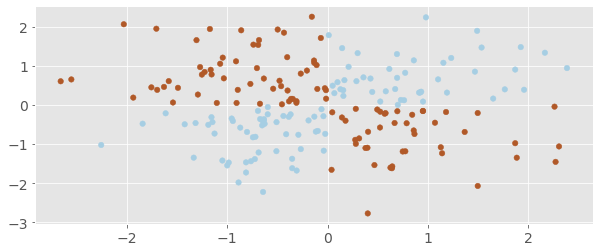

In [172]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
plt.show()

In [173]:
# Функция рисует плоскость согласно предсказаниям классификатора clf
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

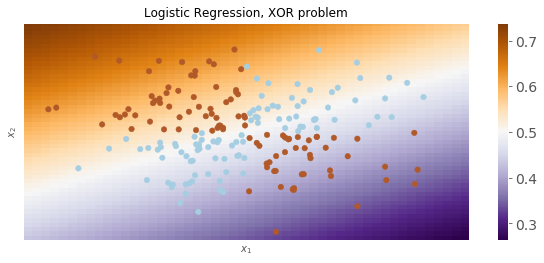

In [177]:
# Применяем логистическую регрессию к нашим данным
# И видим, что линейная модель не способна разделить точки правильно

clf = LogisticRegression()
plot_boundary(clf, X, y, "Logistic Regression, XOR problem")

### Что мы делаем?
Добавляем полиномиальных признаков!

Т.е. получаем несколько признаков из данных путем их возведения в степень и перемножения между собой.

**Пример с двумерными данными, degree=2**

$$\Large (a, b) \rightarrow (1, a, b, a^2, ab, b^2)$$

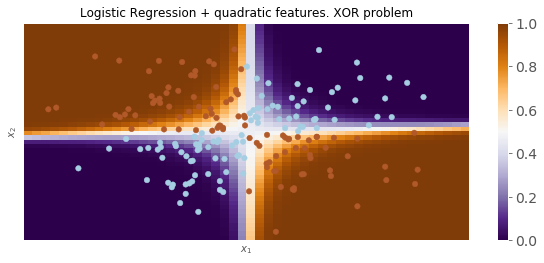

In [178]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])

plot_boundary(logit_pipe, X, y,
        "Logistic Regression + quadratic features. XOR problem")

# Проблема решается!